<a href="https://colab.research.google.com/github/lehuy28/baitap1/blob/main/L1_Spaceship_Titanic_Class_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Spaceship Titanic - (Binary Classification)

**Dataset:** [Kaggle – Spaceship Titanic]  
**Goal:** Predict whether a passenger was **Transported** (True/False).

## Learning objectives
- Perform **data preprocessing** with scikit‑learn (`SimpleImputer`, `OneHotEncoder`, `StandardScaler`, `ColumnTransformer`).
- Make a **train/test split** (with stratification) and understand **data leakage** risks.
- Train classic **supervised models**: **k‑Nearest Neighbors**, **Support Vector Machine**, **Random Forest**.
- Evaluate with **accuracy**, **confusion matrix**, **precision**, **recall**, **F1**, **ROC AUC**, and plot an ROC curve.
- Use **cross‑validation** to compare models.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_recall_fscore_support,
    roc_auc_score, roc_curve
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 100)


In [ ]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Split 'Cabin' into Deck / CabinNum / Side if available
    - Drop obviously non-predictive high-cardinality 'Name'
    """
    out = df.copy()
    if "Cabin" in out.columns:
        # Cabin format like 'B/0/P' -> Deck='B', CabinNum='0', Side='P'
        parts = out["Cabin"].astype("string").str.split("/", expand=True)
        if parts.shape[1] == 3:
            out["Deck"] = parts[0]
            out["CabinNum"] = pd.to_numeric(parts[1], errors="coerce")
            out["Side"] = parts[2]
        # Drop raw Cabin to avoid double-counting
        out = out.drop(columns=["Cabin"])
    # Drop Name if present
    if "Name" in out.columns:
        out = out.drop(columns=["Name"])
    return out


def summarize_metrics(y_true, y_pred, y_score=None, average="binary"):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }
    if y_score is not None:
        # Binary ROC AUC
        try:
            auc = roc_auc_score(y_true, y_score)
            metrics["roc_auc"] = auc
        except Exception as e:
            metrics["roc_auc"] = np.nan
    return metrics


def plot_confusion_matrix(cm, class_names=("False","True"), title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=0)
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)
    # Annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_score, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label="Model")
    ax.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()



## 1) Load the data


In [ ]:
RANDOM_STATE = 10
TRAIN_PATH = "/content/drive/MyDrive/SkillPixel/2025-Olympic-AI/Notebooks/Spaceship_Titanic/train.csv"
TEST_PATH = "/content/drive/MyDrive/SkillPixel/2025-Olympic-AI/Notebooks/Spaceship_Titanic/test.csv"

df = pd.read_csv(TRAIN_PATH) if os.path.exists(TRAIN_PATH) else pd.DataFrame()
df.head(10)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True



## 2) Quick data check


In [ ]:

# display(df.sample(5, random_state=RANDOM_STATE))
display(df.describe(include="all").T.head(20))
print("\nColumns:", list(df.columns))
print("\nTarget distribution (Transported):")
if "Transported" in df.columns:
    print(df["Transported"].value_counts(dropna=False))
else:
    print("Transported column not found in train.csv")


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,9280_02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0



Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Target distribution (Transported):
Transported
True     4378
False    4315
Name: count, dtype: int64



### ✅ Exercise 1 — Identify data issues (short answer)
- List **missing value** hotspots.
- Point out **categorical** vs **numeric** columns.
- Name 1–2 columns you would **drop** (and why).



## 3) Preprocessing pipeline
- `SimpleImputer`: median for numerics, most_frequent for categoricals  
- `StandardScaler`: for numerics (helps kNN/SVM)  
- `OneHotEncoder`: for categoricals


In [ ]:
# Engineer features (Cabin split, drop Name)
df_fe = engineer_features(df)

# Target
y = df_fe["Transported"].astype(int)
X = df_fe.drop(columns=["Transported", "PassengerId"]) # Drop PassengerId

# Handle boolean columns with NaNs separately before ColumnTransformer
for col in ['CryoSleep', 'VIP']:
    if col in X.columns:
        X[col] = X[col].fillna(False) # Impute boolean columns with False
X["Destination"] = X["Destination"].fillna("Unknown")
X["Deck"] = X["Deck"].fillna("G")
X["Side"] = X["Side"].fillna("S")


# Explicitly define numeric and categorical columns
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum']
cat_cols = ['HomePlanet', 'Destination', 'Deck', 'Side', "CryoSleep", "VIP"]


numeric = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric, num_cols),
        ("cat", categorical, cat_cols),
    ],
    remainder='passthrough' # Keep other columns (none in this case after dropping PassengerId)
)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum']
Categorical columns: ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP']


/tmp/ipython-input-290441020.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].fillna(False) # Impute boolean columns with False



## 4) Train/Test split (stratified)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))


Train shape: (6954, 13) | Test shape: (1739, 13)
Train target balance:
 Transported
1    0.503595
0    0.496405
Name: proportion, dtype: float64



## 5) Fit 3 models: kNN, SVM, RandomForest
We'll wrap each model in a pipeline with the `preprocess` transformer.


,accuracy,precision,recall,f1,roc_auc
model,,,,,
SVM,0.781,0.777,0.795,0.786,0.869
RandomForest,0.787,0.812,0.750,0.780,0.868
kNN,0.761,0.776,0.740,0.757,0.843


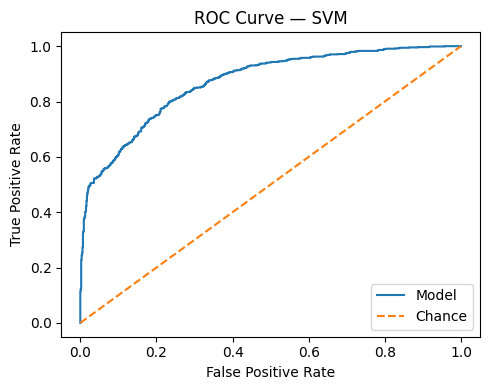

In [ ]:
models = {
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, random_state=RANDOM_STATE)
}

results = []
fitted = {}

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    # Predictions + probabilities for ROC AUC
    y_pred = pipe.predict(X_test)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:, 1]
    else:
        # For models that don't have predict_proba (like some SVMs without probability=True)
        # use decision_function if available, otherwise predict
        if hasattr(pipe.named_steps["clf"], "decision_function"):
             y_score = pipe.decision_function(X_test)
        else:
             y_score = y_pred # Fallback for models without probability or decision_function


    m = summarize_metrics(y_test, y_pred, y_score=y_score, average="binary")
    m["model"] = name
    results.append(m)

results_df = pd.DataFrame(results).set_index("model").sort_values("f1", ascending=False)
display(results_df.round(3))

# Plot ROC for the best model by F1
best_name = results_df["f1"].idxmax()
best_pipe = fitted[best_name]
if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    y_best = best_pipe.predict_proba(X_test)[:, 1]
else:
    if hasattr(best_pipe.named_steps["clf"], "decision_function"):
        y_best = best_pipe.decision_function(X_test)
    else:
        y_best = best_pipe.predict(X_test) # Fallback

plot_roc_curve(y_test, y_best, title=f"ROC Curve — {best_name}")


### Confusion matrix for the best model


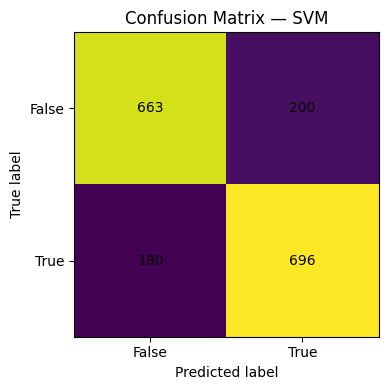

In [ ]:

y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(cm, class_names=("False","True"), title=f"Confusion Matrix — {best_name}")



## 6) Cross‑validation (5‑fold, stratified)
We'll compare models using **accuracy** and **ROC AUC** on the **training** set.


In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_table = []
for name, pipe in fitted.items():
    acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    cv_table.append({
        "model": name,
        "cv_acc_mean": acc.mean(),
        "cv_acc_std": acc.std(),
        "cv_auc_mean": auc.mean(),
        "cv_auc_std": auc.std()
    })
cv_df = pd.DataFrame(cv_table).set_index("model").sort_values("cv_auc_mean", ascending=False)
display(cv_df.round(3))


,cv_acc_mean,cv_acc_std,cv_auc_mean,cv_auc_std
model,,,,
RandomForest,0.811,0.012,0.888,0.010
SVM,0.806,0.009,0.887,0.008
kNN,0.798,0.004,0.878,0.006



## 7) Exercises (hands‑on)
### 🧩 Exercise 2 — Stronger feature engineering
Implement the following and compare metrics vs. baseline:
1. Create a new feature **`TotalSpend = RoomService + FoodCourt + ShoppingMall + Spa + VRDeck`**.
2. Create binary feature **`AnySpend = (TotalSpend > 0)`**.
3. (Optional) Convert `Age` into **buckets** (e.g., child/teen/adult/senior) and one‑hot encode them.
4. (Optional) Try a **log transform** on `TotalSpend` with `FunctionTransformer`.


In [ ]:

df_fx = df.copy()
# TODO: implement feature engineering
spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for c in spend_cols:
    if c not in df_fx.columns:
        df_fx[c] = np.nan
# 1) TotalSpend
df_fx["TotalSpend"] = df_fx[spend_cols].sum(axis=1, skipna=True)
# 2) AnySpend
df_fx["AnySpend"] = (df_fx["TotalSpend"] > 0).astype(int)

# 3) Optional: Age buckets (uncomment to try)
# bins = [-1, 12, 18, 60, 200]
# labels = ["child", "teen", "adult", "senior"]
# df_fx["AgeBucket"] = pd.cut(df_fx["Age"], bins=bins, labels=labels)

# 4) Optional: Log transform (avoid inf on zeros)
# def log1p_safe(x):
#     return np.log1p(np.clip(x, a_min=0, a_max=None))
# log_tf = FunctionTransformer(log1p_safe, validate=False)
# You can integrate log_tf in a ColumnTransformer, or precompute a column:
# df_fx["TotalSpend_log1p"] = log1p_safe(df_fx["TotalSpend"])

# Re‑run pipeline quickly
dfe = engineer_features(df_fx)
y2 = dfe["Transported"].astype(int)
X2 = dfe.drop(columns=["Transported"])

num2 = X2.select_dtypes(include=[np.number]).columns.tolist()
cat2 = [c for c in X2.columns if c not in num2]

pre2 = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num2),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat2),
])

Xtr2, Xte2, ytr2, yte2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=RANDOM_STATE)

pipe2 = Pipeline([("pre", pre2), ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE))])
pipe2.fit(Xtr2, ytr2)
ypred2 = pipe2.predict(Xte2)
yscore2 = pipe2.predict_proba(Xte2)[:, 1]
res2 = summarize_metrics(yte2, ypred2, y_score=yscore2, average="binary")
print("RandomForest + engineered features:", {k: round(v, 3) for k, v in res2.items()})



### 🧩 Exercise 3 — Hyperparameter search
Pick **one** of the models and run a **GridSearchCV**:
- For **kNN**: search `n_neighbors` over a small range.
- For **SVM**: search over `C` and `gamma` on a small grid.
- For **RandomForest**: vary `n_estimators`, `max_depth`, `min_samples_split`.

> Use `scoring="roc_auc"` and `cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)`.



## 9) Reflection
- Which model performed best and why do you think it did?
- One additional feature you would engineer next time.
- One pitfall you avoided (or hit!) related to data leakage or evaluation.
